## Imports
All the necessary libraries
- tensorflow (tf)
    - a machine learning framework
- PIL (Python Image Library) 
    - to look at images easily
- Numpy (np)
    - convert images to matrices and other math functions
- keras
    - high level API to interface with tf and perform ML tasks
- Matplotlib
    - to plot relevant data and show images
- Technically Jupyter Notebook
    - enabled live scripting for easy coding and testing


data:
https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


In [17]:
from PIL import Image
import tensorflow as tf
from keras import Sequential, layers
import keras
import os
import matplotlib.pyplot as plt
import numpy as np


## Preproccessing

we have to convert all images to 224px x 224px. (not here though)
using keras we split the data into a training dataset and validating dataset
**this is important as we can not test on data we trained the model with**

The bottom code is just to show the images while I was writing the code


Found 11259 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


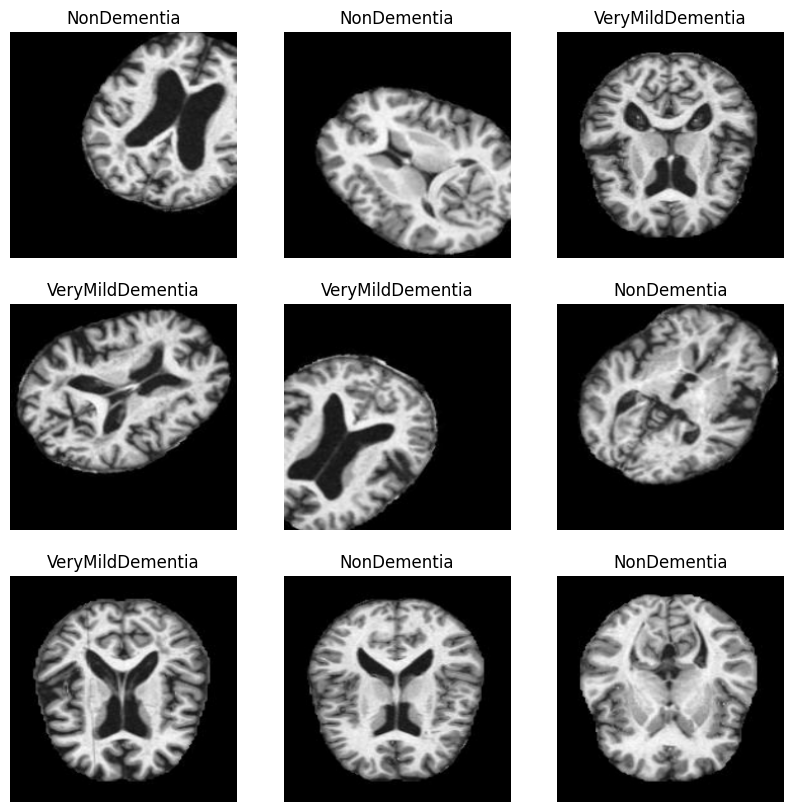

In [31]:
from tensorflow.python.data import AUTOTUNE

img_size = (224,224)


train_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/train',
    labels='inferred',
    # label_mode='categorical',
    batch_size=100,
    image_size=img_size)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/test',
    labels='inferred',
    # label_mode='categorical',
    batch_size=100,
    image_size=img_size)

# batch_1=train_ds.take(1)


def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)



class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
validation_ds.class_names = class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[list(labels[i].numpy()).index(1)])
    plt.axis("off")

We normalize the data to 0-1 from 0-255

In [32]:
class_names = train_ds.class_names
print(class_names)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
0.0 0.98360854


## Data augmentation

This is to expand or dataset and add variance, so the dataset is not over-fitted to our certain set of images. We wrote a function to do this in a separate file for readability. The function takes in a directory with images and outputs the original image and 3 augmented images. These augmented images have been rotated, flipped horizontally and vertically, shift in both the X and Y direction, and a shift transformation.

Alzheimer_s Dataset\train\MildDemented
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem627_augment(0).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem627_augment(1).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem627_augment(2).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem653_augment(2)_augment(0).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem653_augment(2)_augment(1).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem653_augment(2)_augment(2).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem421_augment(0).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem421_augment(1).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem421_augment(2).jpg
Saved augmented image: Alzheimer_s Dataset\train\MildDemented\mildDem548_augment(0).jpg
Saved augmented image: Alzheimer_s Dataset\train

ValueError: num must be an integer with 1 <= num <= 4, not 5

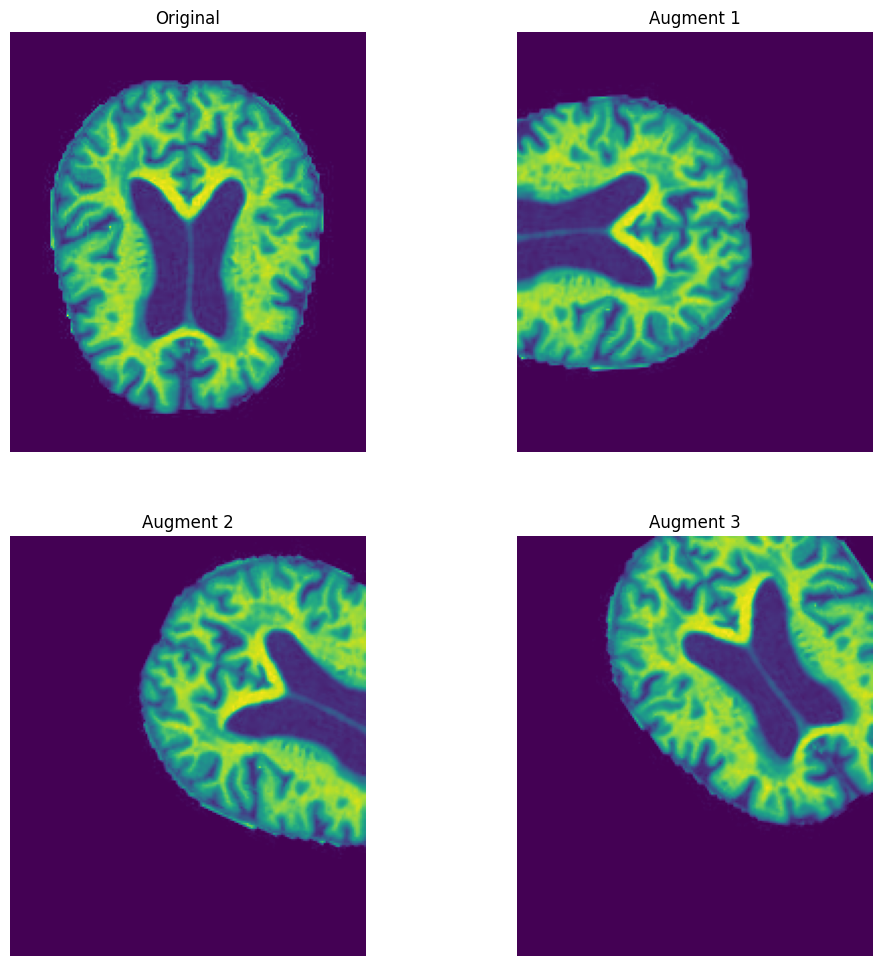

In [33]:
from Augment import load_and_augment
from PIL import Image
import os
import matplotlib.pyplot as plt

starting_dir = "Alzheimer_s Dataset\\train"
image_labels = ["Original", "Augment 1", "Augment 2", "Augment 3"]
labels = os.listdir(starting_dir)
for label in labels:
    curr_dir = os.path.join(starting_dir, label)
    # print(curr_dir)
    augmented_imgs = load_and_augment(curr_dir, .01)
    plt.figure(figsize=(12, 12))
    plt.subplot(2,2,4)
    print("iter")
    i = 0
    for i, img in enumerate(augmented_imgs):
        # plt.figure(figsize=(12, 12))
        # i += 1
        plt.subplot(2,2,i+1)
        plt.title(image_labels[i])
        plt.imshow(img)
        plt.axis('off')


    plt.tight_layout()
    plt.show()
        
    


## Defining the Model

here we utilize MobileNet as a base architecture and use imagenet weights as a good starting point.

then we define a keras model which takes the 1000 classes from mobilenet and cuts it down to 4 which represent our 4 classes

input: resized images --- MobileNet w imagenet weights --> 1000 classes --- Dense layer --> our 4 classes

In [34]:
num_classes = len(class_names)

model_MN = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model_MN.trainable = True

model = keras.Sequential([
    # layers.Resizing(224, 224, input_shape=(176, 208, 3)),
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    model_MN,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.build(img_size)


here im just compiling the model

idk what adam optimization and loss is

In [35]:
METRICS = [tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=METRICS)


In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 1000)              4253864   
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               128128    
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 4382508 (16.72 MB)
Trainable params: 4360620 (16.63 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


epochs is how many times the model trains on every image in the training set

and then I fit the network to the training set

In [28]:
epochs=2
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs                                                                                             
)
print("Evaluate on test data")
results = model.evaluate(validation_ds, batch_size=1)
print("test loss, test acc:", results)

Epoch 1/2
352/352 [==============================] - 595s 2s/step - loss: 0.4756 - accuracy: 0.5147 - val_loss: 0.5580 - val_accuracy: 0.4996
Epoch 2/2
352/352 [==============================] - 589s 2s/step - loss: 0.4356 - accuracy: 0.5510 - val_loss: 0.4406 - val_accuracy: 0.5567
Evaluate on test data
40/40 [==============================] - 16s 391ms/step - loss: 0.4406 - accuracy: 0.5567
test loss, test acc: [0.440560907125473, 0.5566849112510681]


In [ ]:

img_path = "Alzheimer_s Dataset/test/ModerateDemented/27.jpg"
img = Image.open(img_path)
# img_size
img_resized = img.resize(img_size)
# np_img = np.asarray(img_resized)
img_resized.size


In [ ]:
predictions = model.predict(np.asarray(img_resized))